In [1]:
import os
import os.path as osp
import re
import json
import sqlite3
import pandas as pd
from scipy.stats import gmean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import utils

db_dir = osp.abspath(osp.join('..', 'db-checkpoints'))
assert osp.exists(db_dir)
path = osp.join(db_dir, 'db-2024-08-21:21:18.sqlite3')
assert osp.exists(path)

save_dir = 'accuracy'

if not osp.exists(save_dir):
    os.mkdir(save_dir)

query = '''SELECT * FROM results r '''

with sqlite3.connect(path) as con:
    df = pd.read_sql(query, con)
    
ligands_replacements = {
           '4-PhenylImidazole': '4-Phenylimidazole',
           '4-Phenylimidazole': '4-Phenylimidazole',
           'Aracadionic acid': 'Aracadionic acid',
           'Arachadionic Acid': 'Aracadionic acid',
           'Arachadionic acid': 'Aracadionic acid',
           'Arachadionic': 'Aracadionic acid',
           'Buffer Only': 'Buffer Only',
           'Buffer': 'Buffer Only', 
           'DMSO': None,
           'Lauric Acid': 'Lauric acid', 
           'Lauric acid': 'Lauric acid',
           'Palmitic Acid': 'Palmitic acid',
           'Palmitic acid': 'Palmitic acid',
           'Protein Only': None,
           'SDS': 'SDS',
          }

df['ligand'] = df['ligand'].replace(ligands_replacements)

df_ok = df.loc[df['ok'] == True, :]

df_ok['vmax_norm'] = df_ok['vmax'] /  df['a420_max']

df_ok.head()

/tmp/ipykernel_242242/3568572109.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ok['vmax_norm'] = df_ok['vmax'] /  df['a420_max']


,id,experiment_number,centrifuge_minutes,centrifuge_rpm,dispense_bulk,volume,protein_name,dispense_ligands,protein_days_thawed,well_volume,...,rsq,a420_max,auc_mean,auc_cv,std_405,dd_soret,fig,visited,ok,vmax_norm
1,2,3,NaN,NaN,Manual,50.0,None,Serial dilution,2,50.0,...,0.930252,0.421034,37.665803,0.067667,0.008379,0.001065,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,0.033401
2,3,3,NaN,NaN,Manual,50.0,None,Serial dilution,2,50.0,...,0.745274,0.410596,34.967277,0.070659,0.007526,0.001803,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,0.061762
3,4,3,NaN,NaN,Manual,50.0,None,Serial dilution,2,50.0,...,0.958755,0.363122,30.399167,0.026657,0.003079,-0.000334,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,0.406300
4,5,3,NaN,NaN,Manual,50.0,None,Serial dilution,2,50.0,...,0.995271,0.382079,32.132123,0.028020,0.004944,-0.001453,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,0.521219
5,6,3,NaN,NaN,Manual,50.0,None,Serial dilution,2,50.0,...,0.947643,0.378355,32.378308,0.046191,0.005632,0.000549,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,0,1,0.641885


## Distributions of Michaelis Menten Metrics - Plate Assay

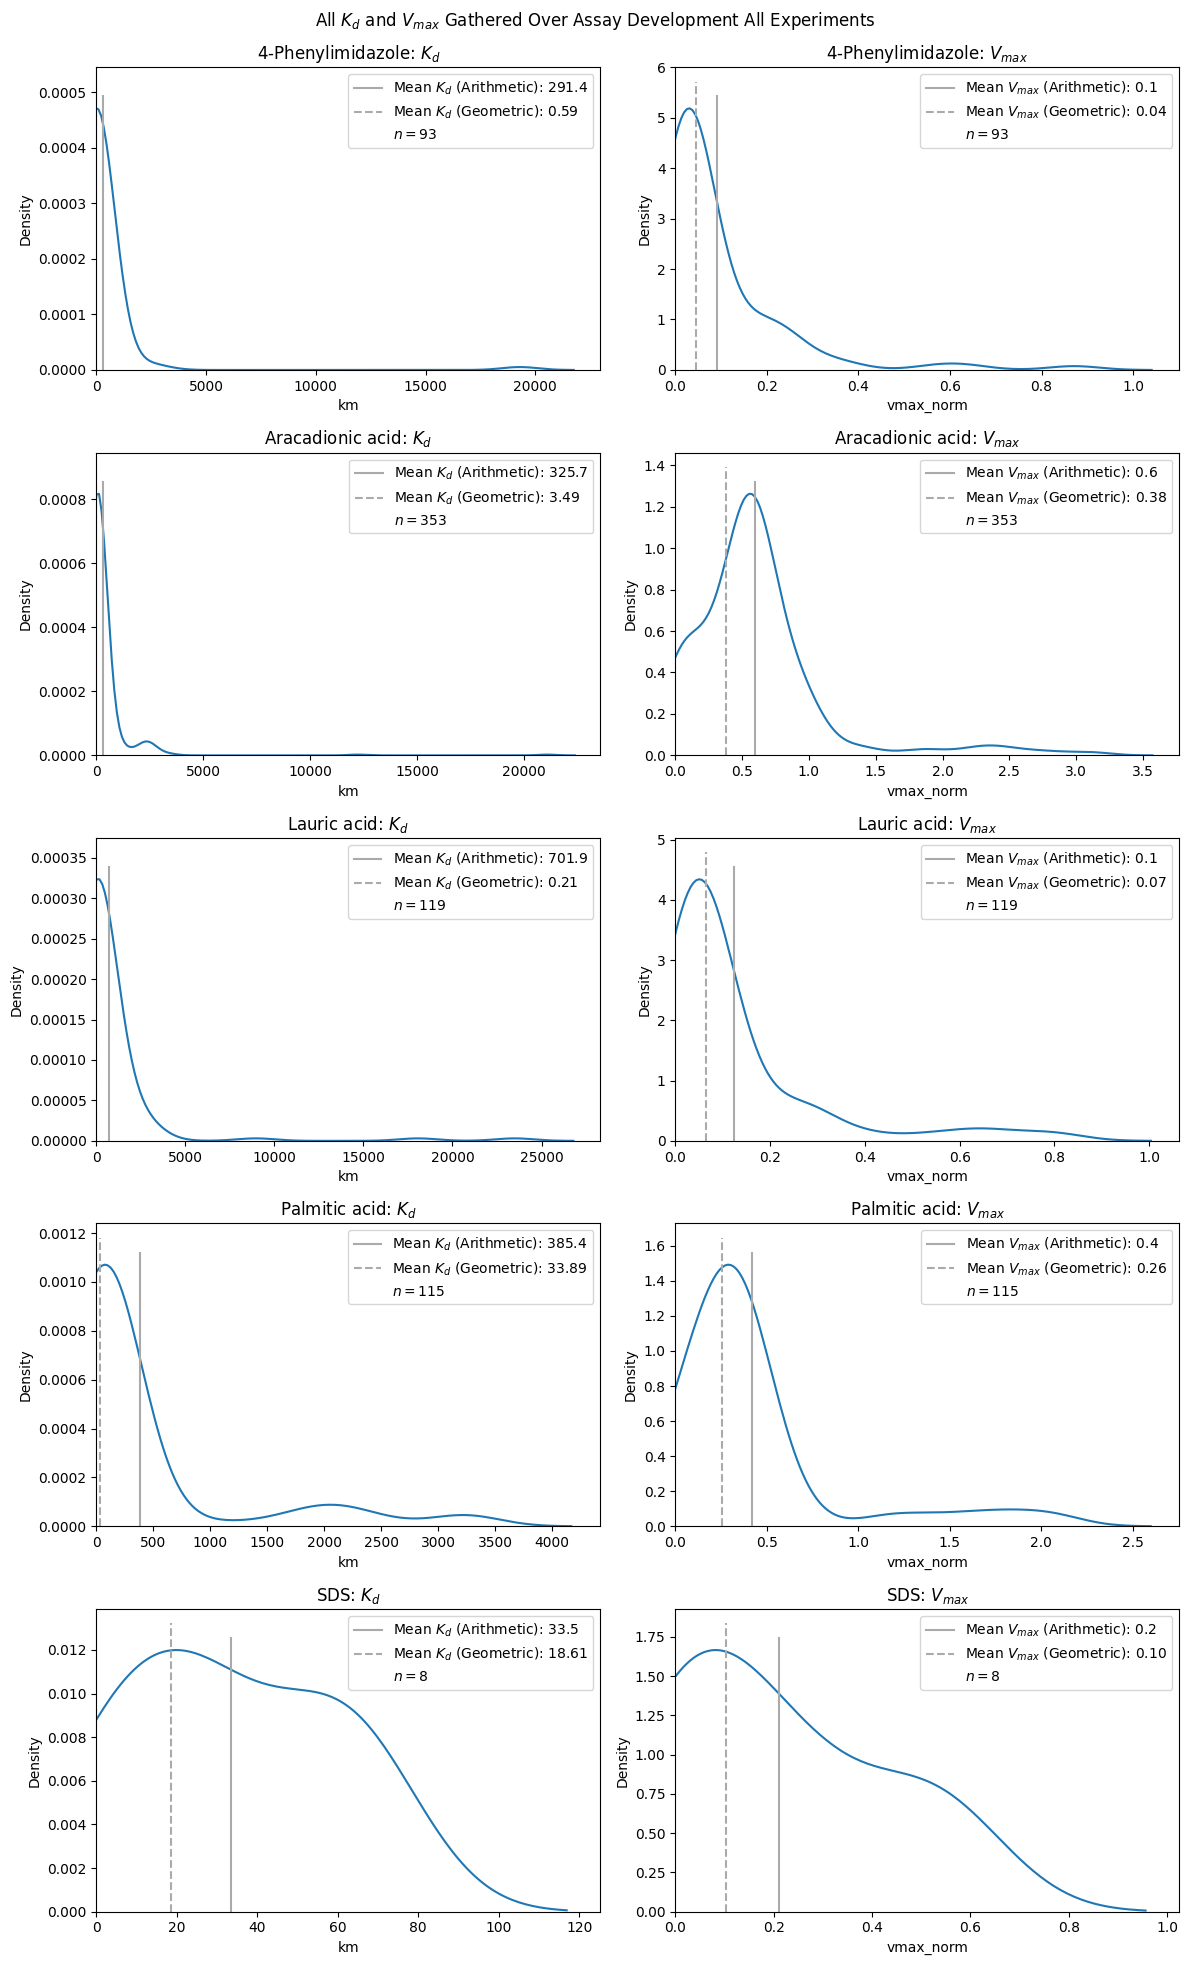

In [2]:
 def plot_mm_summary(df, save_path_suffix, title_label):
    n_ligands = len(df['ligand'].dropna().unique())
    fig, axs = plt.subplots(n_ligands, 2, figsize=(12, 4 * n_ligands))
    
    for (ligand_name, ligand_df), ax in zip(df.groupby('ligand'), axs):
    
        for metric, metric_symbol, ax_ in zip(['km', 'vmax_norm'], ['$K_d$', '$V_{max}$'], ax):
            
            kms_nonzero = ligand_df.loc[ligand_df[metric] > 0, metric]
            mean_ar = kms_nonzero.mean()
            mean_g =  gmean(kms_nonzero)
        
            sns.kdeplot(x=ligand_df.loc[:, metric],
                       ax=ax_,
                       )
        
            ax_.vlines(x=mean_ar,
                      ymin=0,
                      ymax=ax_.get_ylim()[1],
                      linestyle='-',
                      color='#aaa',
                     )
            ax_.vlines(x=mean_g,
                      ymin=0,
                      ymax=ax_.get_ylim()[1],
                      color='#aaa',
                      linestyle='--',
                     )
        
            mean_ar_line = plt.matplotlib.lines.Line2D([], [], color='#aaa', linestyle='-', label=f'Mean {metric_symbol} (Arithmetic): {mean_ar:.1f}')
            mean_g_line = plt.matplotlib.lines.Line2D([], [], color='#aaa', linestyle='--', label=f'Mean {metric_symbol} (Geometric): {mean_g:.2f}')
            
            ax_.set_title(f'{ligand_name}: {metric_symbol}')
            ax_.set_xlim(0, ax_.get_xlim()[1])
            count_patch = mpatches.Patch(color='none',  label=f'$n = {len(ligand_df)}$')
            
            ax_.legend(handles=[mean_ar_line, mean_g_line, count_patch],
                      loc='upper right')  # include the line objects
    
    fig.suptitle(f'All $K_d$ and $V_{{max}}$ Gathered Over Assay Development {title_label}\n')
    plt.tight_layout()
    plt.savefig(osp.join(save_dir, f'mm-metrics-{save_path_suffix}.png'))
    plt.show()
     
plot_mm_summary(df_ok, 'all', 'All Experiments')

## Validation Experiments

- Manual Serial Dilution: 11
- Echo: 19, 22

20


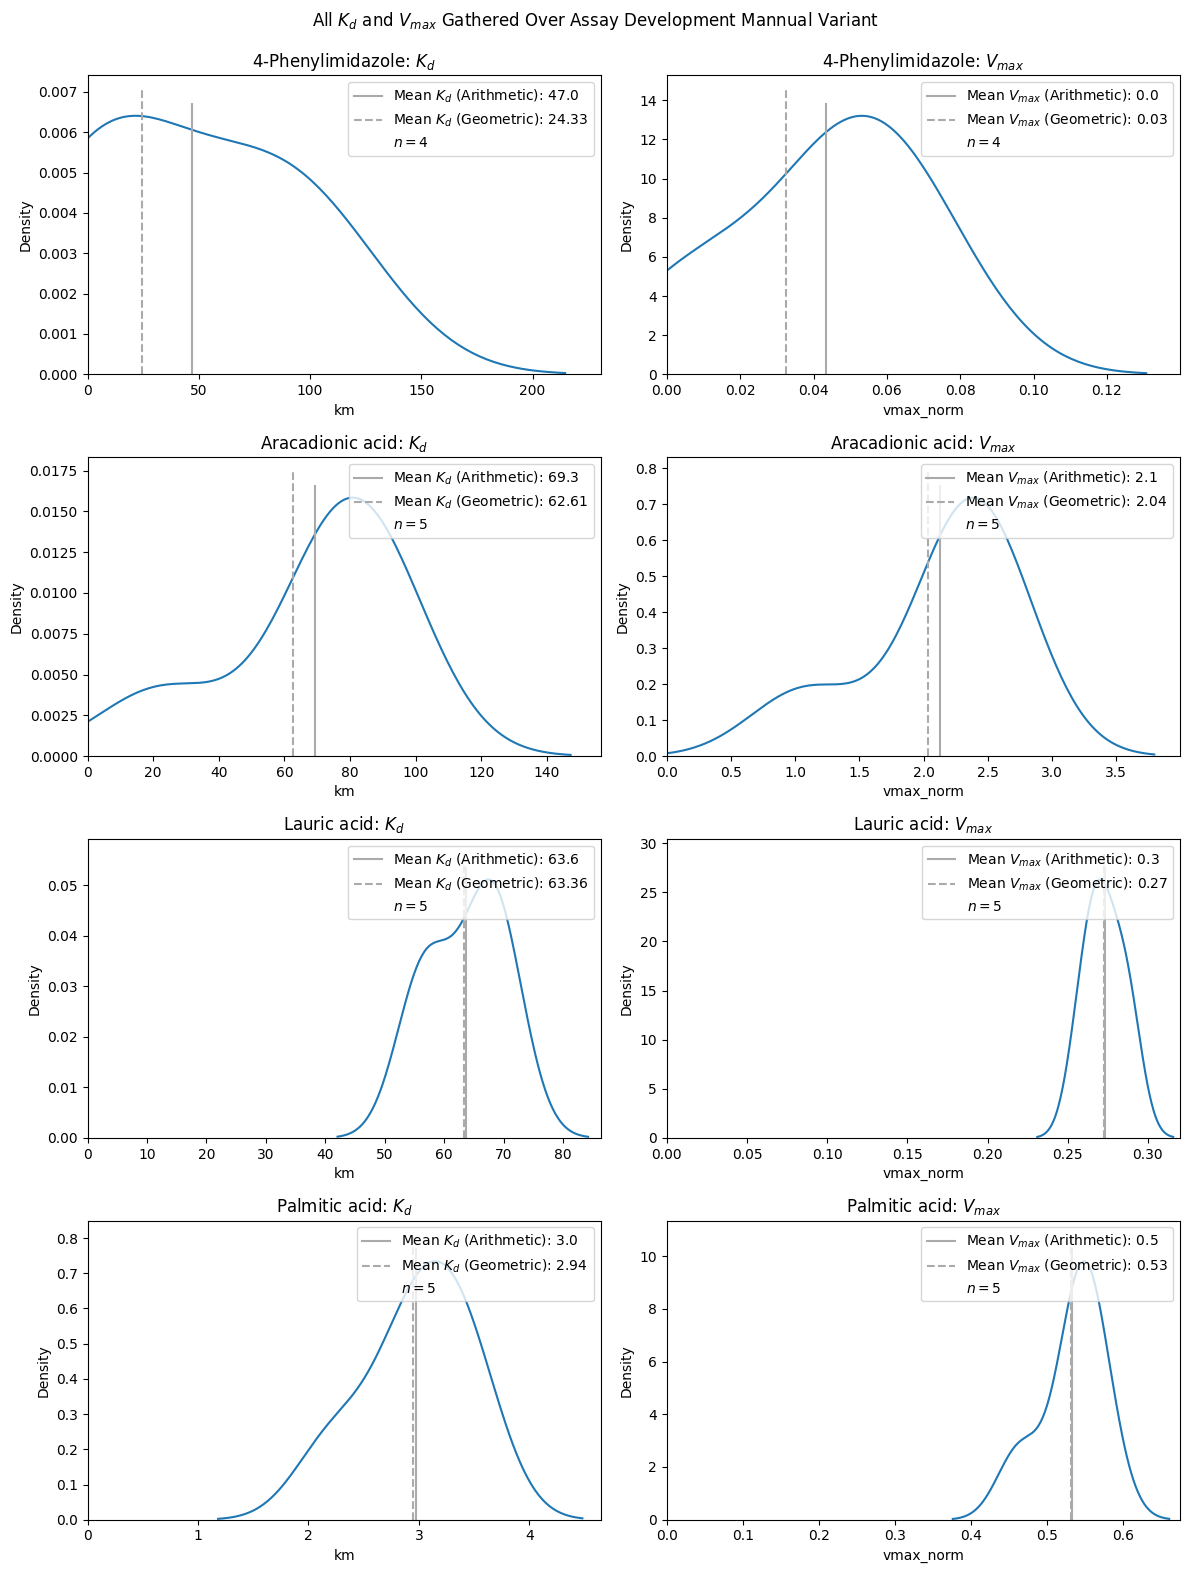

In [3]:
df_ok_manual_validation = df_ok.loc[df_ok['experiment_number'] == 11, :]

print(len(df_ok_manual_validation))
plot_mm_summary(df_ok_manual_validation, 'manual', 'Mannual Variant')

229


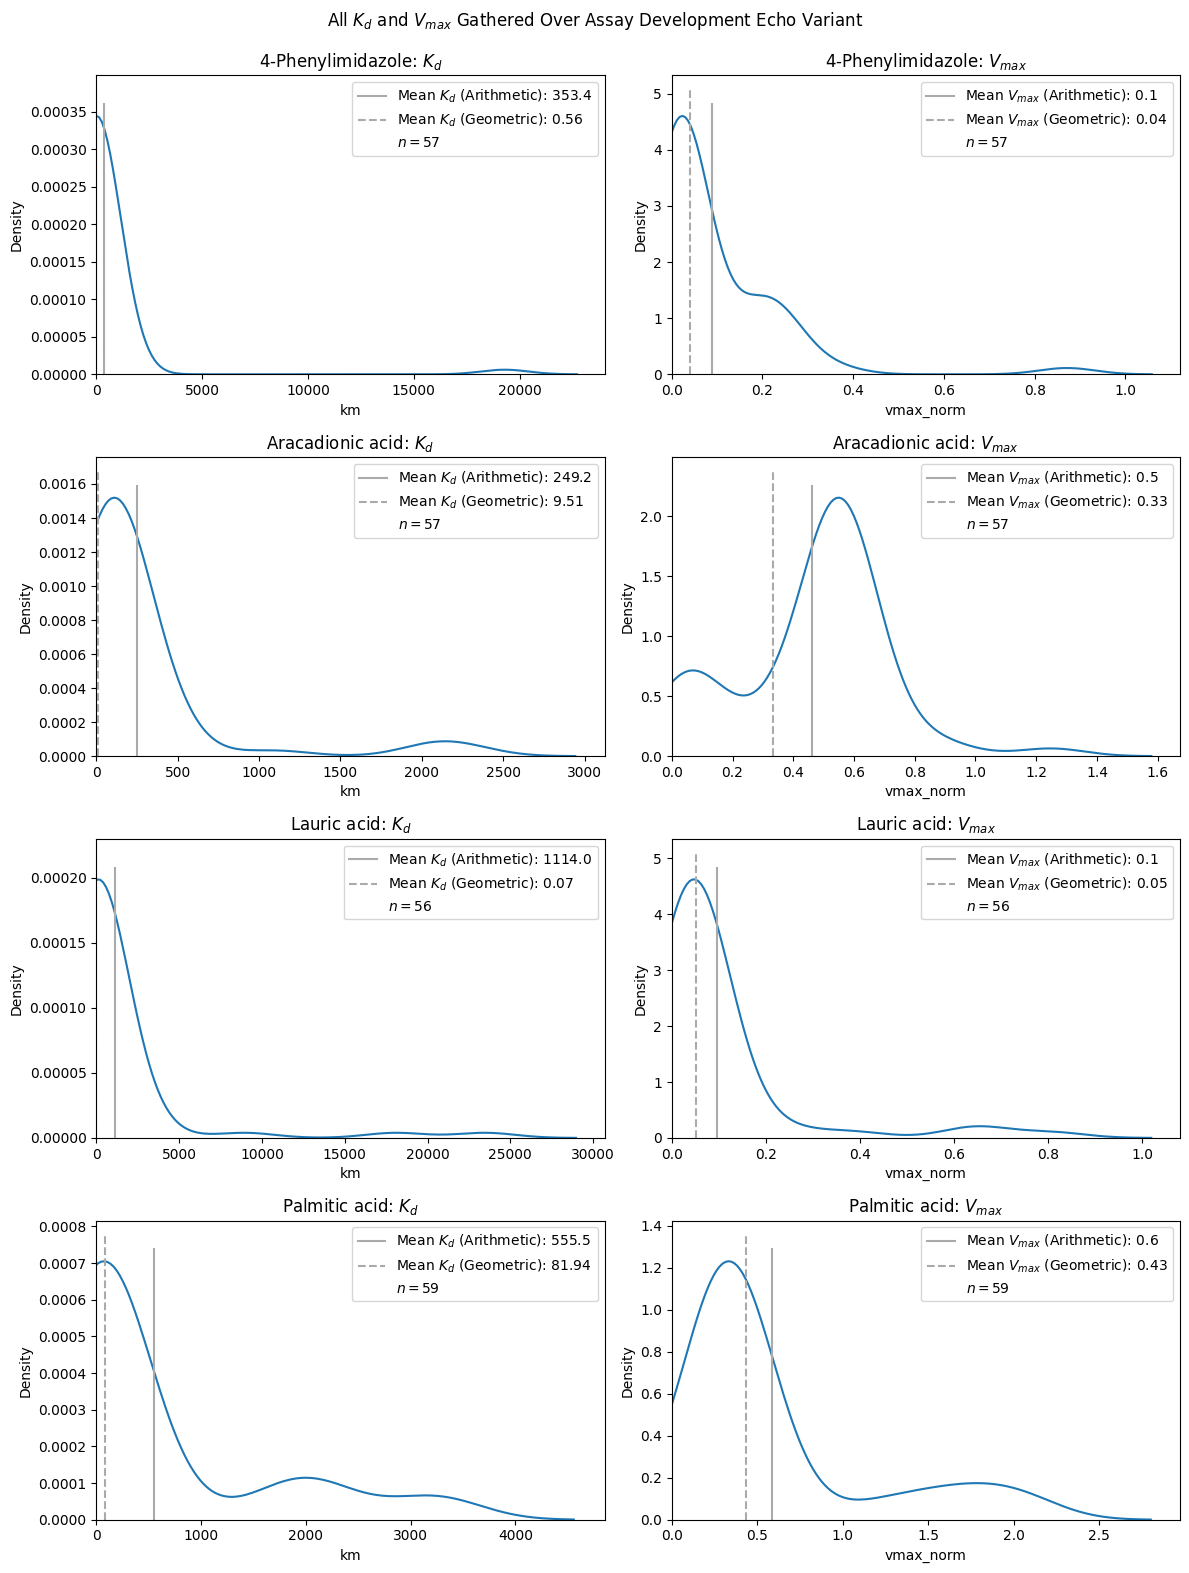

In [5]:
df_ok_echo_validation = df_ok.query('experiment_number in (19, 22)')
print(len(df_ok_echo_validation))
plot_mm_summary(df_ok_echo_validation, 'echo', 'Echo Variant')

In [16]:
o = []

for df, experiment_name in zip([df_ok_manual_validation, df_ok_echo_validation],
                               ['Manual Validation', 'Echo Validation']):
    
    for ligand_name, ligand_df in df.groupby('ligand'):
        kms_nonzero = ligand_df.loc[ligand_df['km'] > 0, 'km']
        vmax_nonzero = ligand_df.loc[ligand_df['vmax'] > 0, 'vmax']
        
        o.append({'experiment_name': experiment_name,
                  'ligand_name': ligand_name,
                  'km_mean_ar': kms_nonzero.mean(),
                  'km_mean_g':  gmean(kms_nonzero),
                  'km_std': kms_nonzero.std(),
                  'km_cv': kms_nonzero.std() / kms_nonzero.mean(),
                  'vmax_mean_ar': vmax_nonzero.mean(),
                  'vmax_mean_g':  gmean(vmax_nonzero),
                  'vmax_std': vmax_nonzero.std(),
                  'vmax_cv': vmax_nonzero.std() / vmax_nonzero.mean(),
                  'n': len(ligand_df),
                  })
        
o = pd.DataFrame(o)
o

,experiment_name,ligand_name,km_mean_ar,km_mean_g,km_std,km_cv,vmax_mean_ar,vmax_mean_g,vmax_std,vmax_cv,n
0,Manual Validation,4-Phenylimidazole,47.007293,24.328354,48.369291,1.028974,0.007193,0.005418,0.004392,0.610639,4
1,Manual Validation,Aracadionic acid,69.329415,62.609851,26.751334,0.385858,0.401287,0.380155,0.124566,0.310416,5
2,Manual Validation,Lauric acid,63.620555,63.359470,6.377533,0.100243,0.052523,0.052479,0.002378,0.045276,5
3,Manual Validation,Palmitic acid,2.978448,2.944650,0.481341,0.161608,0.092839,0.092451,0.009237,0.099499,5
4,Echo Validation,4-Phenylimidazole,353.440684,0.564421,2553.733983,7.225354,0.013938,0.005003,0.029676,2.129131,57
5,Echo Validation,Aracadionic acid,249.247922,9.513697,484.617516,1.944319,0.067347,0.043943,0.070785,1.051045,57
6,Echo Validation,Lauric acid,1114.023611,0.066633,4075.853731,3.658678,0.015389,0.007189,0.027151,1.764375,56
7,Echo Validation,Palmitic acid,555.469738,81.937776,987.279407,1.777377,0.086687,0.067856,0.070664,0.815168,59


In [73]:
titration_metrics = pd.read_csv('titrations/titration-metrics.csv')
titration_metrics['ligand'] = titration_metrics['ligand'].replace({'4-Phenylimidazole': '4-Phenylimidazole',
                                                                   'Arachadonic Acid': 'Aracadionic acid',
                                                                   'Lauric Acid': 'Lauric acid',
                                                                   'Palmitic Acid': 'Palmitic acid',
                                                                   }
                                                                  )
titration_metrics.head()

,file,ligand,vmax,km,r_squared,experiment_number
0,./19_Validation/TitrationData/20191204_Lauric_...,Lauric acid,0.044889,1366.391682,0.987644,19
1,./19_Validation/TitrationData/20191204_Lauric_...,Lauric acid,0.057109,1619.428856,0.995141,19
2,./19_Validation/TitrationData/20191204_Lauric_...,Lauric acid,0.049522,1578.336316,0.991451,19
3,./19_Validation/TitrationData/20191204_Lauric_...,Lauric acid,0.055193,2305.610106,0.985535,19
4,./19_Validation/TitrationData/20191204_Lauric_...,Lauric acid,0.042295,1399.287693,0.975691,19


## $R$

0.28


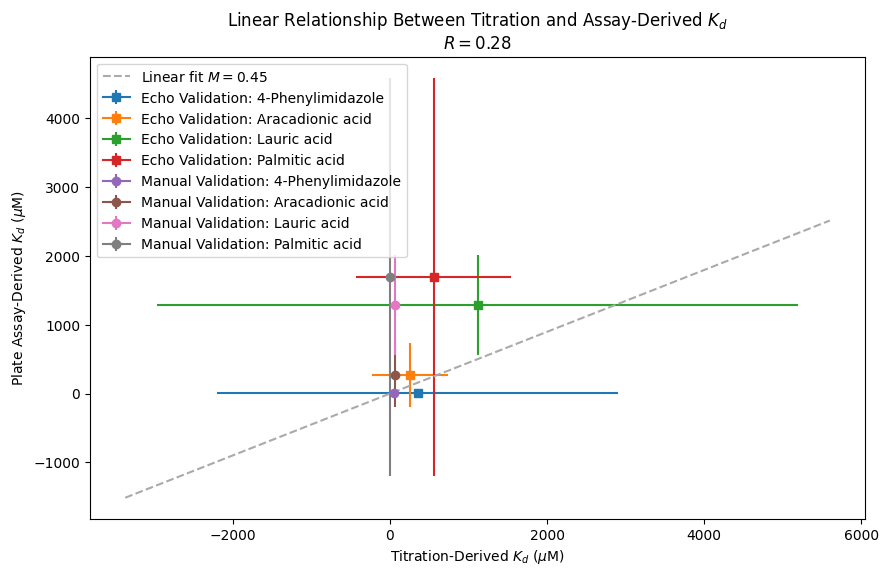

In [111]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

plt.figure(figsize=(10, 6))

pairs = []

for (dispense, ligand), x in o.groupby(['experiment_name', 'ligand_name']):
    assert len(x) == 1
    x_mean =  x['km_mean_ar'].mean()
    x_std =  x['km_std'].mean()
    
    y = titration_metrics.loc[titration_metrics['ligand'] == ligand, :]
    y_mean = y['km'].mean()
    y_std = y['km'].std()

    pairs.append([x_mean, y_mean])

    plt.errorbar(x=x_mean,
                 y=y_mean,
                 yerr=y_std,
                 xerr=x_std,
                 label=f'{dispense}: {ligand}',
                 marker='o' if 'Manual' in dispense else 's'
               )
    
pairs = np.array(pairs)

pearson_coef = pearsonr(x=pairs[:, 0], y=pairs[:, 1])

print(round(pearson_coef.statistic, 2))

line_fn = lambda m, x: m*x

cov, m = curve_fit(line_fn,
                     xdata=pairs[:, 0],
                     ydata=pairs[:, 1],
                    )
m = m[0][0]

x_points = np.linspace(*plt.gca().get_xlim(), 100)
plt.plot(x_points, 
         line_fn(m, x_points),
         color='#aaa',
         linestyle='--',
         label=f'Linear fit $M ={m:.2f}$'
        )

plt.xlabel('Titration-Derived $K_d$ ($\mu$M)')
plt.ylabel('Plate Assay-Derived $K_d$ ($\mu$M)')
plt.title(f'Linear Relationship Between Titration and Assay-Derived $K_d$\n$R = {pearson_coef.statistic:.2f}$')
plt.legend()
plt.savefig(os.path.join(save_dir, 'pearson-r-plot.png'))
plt.show()

4    353.440684
Name: km_mean_ar, dtype: float64